### Metadata

Metadata can be explained in a few ways:

Data that provide information about other data.
Metadata summarizes basic information about data, making finding & working with particular instances of data easier.
Metadata can be created manually to be more accurate, or automatically and contain more basic information.

<div class="alert alert-block alert-success"><b>Step 1</b>: Build metadata structure table.。


</div>

In [ ]:
import pandas as pd
import numpy as np
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
# train test 合并成一个 full set

fullset = pd.concat([train,test],ignore_index=True)

那么，变量类型的逻辑，帮大家梳理一下： 

```diff
- role
+ 对每个列打上标签：序号|标签|特征
```

```diff
- category
+ 1. 列名含有ind表示individual的含义，返回"individual"
+ 2. 列名含有car表示car的含义，返回"car"
+ 3. 列名含有calc表示calculated的含义，返回"calculated"
```


```diff
- level
+ 1. 列名里有`bin`的或者这一列是target，我们归类为`binary` (if)
+ 2. 列名里有`cat`的或者这一列是id，归类为`nominal` (elif)
+ 3. 数据类型为`float`的是`interval` (elif)
+ 4. 数据类型是`int`的是`ordinal` (elif)

@ ordinal 解释一下：刨除开前面的情况，剩下的特征，如果他们的数据类型是`int`，我们认为他们是ordinal的，因为整数的排列是有序的，我们认为2>1，3>2等等，对应值的影响程度也满足这样的序列关系（虽然我们不知道值的具体含义）

```

In [ ]:
def meta(train,test,missing_values = -1,cols_ignore_missing = []):
    
    df = pd.concat([train,test]).reset_index(drop=True).fillna('未知')
    data = []
    for col in df.columns:
        # define role
        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'feature'
        
        # define category
        if 'ind' in col:
            category = 'individual'
        elif 'car' in col:
            category = 'car'
        elif 'calc' in col:
            category = 'calculated'
        elif 'reg' in col:
            category = 'region'
        else:
            category = 'other'
        
        
        # define level of measurements
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col[-3:] or col == 'id':
            level = 'nominal'
        elif df[col].dtype == 'float64' and df[col].replace(missing_values,np.nan).max()-df[col].replace(missing_values,np.nan).min() > 1:
            level = 'interval'
        elif df[col].dtype == 'float64' and df[col].replace(missing_values,np.nan).max()-df[col].replace(missing_values,np.nan).min() <= 1:
            level = 'ratio'
        elif df[col].dtype == 'int64':
            level = 'ordinal'
            
        # 定义 data type
        dtype = df[col].dtype
        
        # define unique
        if col == 'id' or df[col].dtype == 'float64':
            uniq = 'Ignore'
        else:
            if col in cols_ignore_missing:
                uniq = df[col].nunique()
            else:
                uniq = df[col].replace({missing_values:np.nan}).nunique()
                
        # 定义 cardinality
        if uniq == 'Ignore':
            cardinality = 'Ignore'
        elif uniq <= 10:
            cardinality = 'Low Cardinality'
        elif uniq <= 30:
            cardinality = 'Medium Cardinality'
        else:
            cardinality = 'High Cardinality'
        
        # 定义 missing
        if col in cols_ignore_missing:
            missing = 0
        else:
            missing = sum(df[col] == missing_values)
            
        # 定义 missing percent
        missing_percent = f'{missing}({round(missing*100/len(df),2)}%)'
        
        # 定义 imputation
        if missing > df.shape[0]*0.4:
            imputation = 'remove'
        elif missing > 0:
            if level == 'binary' or level == 'nominal':
                imputation = ('mode')
            if level == 'ordinal':
                imputation = ('mode','median')
            if level == 'interval' or level == 'ratio':
                imputation = ('mode','median','mean')        
        else:
            imputation = "No Missing"
            
        # 定义 keep
        keep = True
        if col  == 'id' or imputation == 'remove':
            keep = False
        col_dict = {
            'colname': col,
            'role': role,
            'category': category,
            'level': level,
            'dtype': dtype,
            'cardinality': uniq,
            'cardinality_level':cardinality,
            'missing': missing,
            'missing_percent': missing_percent,
            'imputation':imputation,
            'keep': keep,
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=list(col_dict.keys()))
    meta.set_index('colname', inplace=True)
    
    return meta

In [ ]:
metadata = meta(train,test)

In [ ]:
metadata

,role,category,level,dtype,cardinality,cardinality_level,missing,missing_percent,imputation,keep
colname,,,,,,,,,,
id,id,other,nominal,int64,Ignore,Ignore,0,0(0.0%),No Missing,False
target,target,other,binary,object,3,Low Cardinality,0,0(0.0%),No Missing,True
ps_ind_01,feature,individual,ordinal,int64,8,Low Cardinality,0,0(0.0%),No Missing,True
ps_ind_02_cat,feature,individual,nominal,int64,4,Low Cardinality,523,523(0.04%),mode,True
ps_ind_03,feature,individual,ordinal,int64,12,Medium Cardinality,0,0(0.0%),No Missing,True
ps_ind_04_cat,feature,individual,nominal,int64,2,Low Cardinality,228,228(0.02%),mode,True
ps_ind_05_cat,feature,individual,nominal,int64,7,Low Cardinality,14519,14519(0.98%),mode,True
ps_ind_06_bin,feature,individual,binary,int64,2,Low Cardinality,0,0(0.0%),No Missing,True
ps_ind_07_bin,feature,individual,binary,int64,2,Low Cardinality,0,0(0.0%),No Missing,True


<div class="alert alert-block alert-success"><b>Step 3</b>: 
    
请基于meta，找出各个数据角色、变量类型各有多少个特征，目标形成下图的dataframe！
</div>

In [ ]:
metadata.groupby(['role','level']).size().reset_index(name = 'count')

,role,level,count
0,feature,binary,17
1,feature,interval,5
2,feature,nominal,14
3,feature,ordinal,16
4,feature,ratio,5
5,id,nominal,1
6,target,binary,1


<div class="alert alert-block alert-success"><b>Step 4 (3分)</b>: 
    
请基于meta，对连续型变量做统计描述型分析，使用describe函数！
    
- 请问连续型变量里面存在缺失值的有哪些？
- 请问连续型变量里面标准差最小的变量名称是什么？
- 请问连续型变量里面最大值大于4的变量名称是什么？
    
</div>

In [ ]:
# 提示：用describe函数
stats = fullset[metadata[metadata.dtype == 'float64'].index].describe()
stats

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06,1.488028e+06
mean,6.110305e-01,4.395943e-01,5.514848e-01,3.799519e-01,8.134878e-01,2.763614e-01,3.067355e+00,4.496817e-01,4.501073e-01,4.499718e-01
std,2.876763e-01,4.045123e-01,7.938159e-01,5.836187e-02,2.247024e-01,3.569623e-01,7.299510e-01,2.872071e-01,2.871817e-01,2.872136e-01
min,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,2.506191e-01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e-01,2.000000e-01,5.250000e-01,3.162278e-01,6.710052e-01,3.339162e-01,2.828427e+00,2.000000e-01,2.000000e-01,2.000000e-01
50%,7.000000e-01,3.000000e-01,7.211103e-01,3.741657e-01,7.660406e-01,3.687818e-01,3.316625e+00,4.000000e-01,5.000000e-01,5.000000e-01
75%,9.000000e-01,6.000000e-01,1.001561e+00,4.000000e-01,9.061429e-01,3.964846e-01,3.605551e+00,7.000000e-01,7.000000e-01,7.000000e-01
max,9.000000e-01,1.800000e+00,4.423517e+00,1.264911e+00,4.031301e+00,6.363961e-01,3.741657e+00,9.000000e-01,9.000000e-01,9.000000e-01


不要用眼睛看结果，要用代码逻辑输出哦！

In [ ]:
# 请问连续型变量里面存在缺失值的有哪些？

stats.columns[stats.loc['min'] == -1]

Index(['ps_reg_03', 'ps_car_12', 'ps_car_14'], dtype='object')

In [ ]:
# 请问连续型变量里面标准差最小的变量名称是什么？

stats.loc['std'].nsmallest(1).index[0]

'ps_car_12'

In [ ]:
# 请问连续型变量里面最大值大于4的变量名称是什么？

stats.columns[stats.loc['max'] > 4]

Index(['ps_reg_03', 'ps_car_13'], dtype='object')

<div class="alert alert-block alert-success"><b>Step 5</b>: 
    
根据下列代码和对应的结果，你有什么发现么？
    
</div>

你有什么发现么？

<AxesSubplot:>

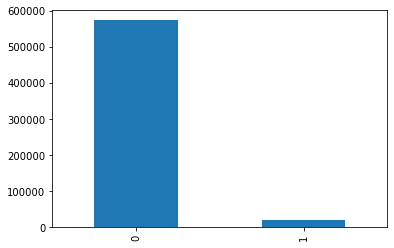

In [ ]:
train.target.value_counts().plot(kind = 'bar')

0占了绝大对数，也就代表，这些case里面发起索赔的占比是非常小的，那么对于这种类别占比极度不平衡的数据，是不是会影响到模型的建立？

<div class="alert alert-block alert-success"><b>Step 6</b>: 
    
`from data_management import data_report`
    
看看这个函数都能得到什么信息！
    
</div>

In [ ]:
import pandas as pd
import numpy as np
import colorama
from colorama import Fore, Style
from tabulate import tabulate

In [ ]:
def data_report(train,test,metadata,verbose = False):
    
    fullset = pd.concat([train,test]).reset_index(drop=True).fillna('未知')
    
    print(f"train总行数：{Fore.RED}{train.shape[0]}{Style.RESET_ALL} | test总行数：{Fore.BLUE}{test.shape[0]}{Style.RESET_ALL}")
    print(f"train总列数：{Fore.RED}{train.shape[1]}{Style.RESET_ALL} | test总列数：{Fore.BLUE}{test.shape[1]}{Style.RESET_ALL}")
    print(f"train总元素数：{train.size}")
    print(f"test总元素数：{test.size}")
    print('-'*50+ f"{Fore.RED}INFO{Style.RESET_ALL}"  + '-'*50)
    print('【train info】')
    train.info(verbose = verbose)
    print('-'*104)
    print('【test info】')
    test.info(verbose = verbose)
    
    if verbose:
    
        print('-'*48 + f"{Fore.RED}SUMMARY{Style.RESET_ALL}" + '-'*48)


        ############ SUMMARY #############
        print('*'*48 + f"{Fore.BLUE} COUNTS {Style.RESET_ALL}" + '*'*48)
        print('【Counts groupby role & level】'.upper())
        role_level_count = pd.DataFrame(
        {
            'count':metadata.groupby(['role','level']).size()
        }
        ).reset_index().sort_values(by = 'count',ascending=False)
        print(tabulate(role_level_count,tablefmt="grid",headers = ['role','level','count']))

        print('【Counts groupby role & category】'.upper())
        role_cate_count = pd.DataFrame(
        {
            'count':metadata.groupby(['role','category']).size()
        }
        ).reset_index().sort_values(by = 'count',ascending=False)
        print(tabulate(role_cate_count,tablefmt="grid",headers = ['role','category','count']))

        print('【Counts groupby role & cardinality_level】'.upper())
        role_cardinality_count = pd.DataFrame(
        {
            'count':metadata.groupby(['role','cardinality_level']).size()
        }
        ).reset_index().sort_values(by = 'count',ascending=False)
        print(tabulate(role_cardinality_count,tablefmt="grid",headers = ['role','cardinality_level','count']))


        print('*'*48 + f"{Fore.BLUE} MISSING {Style.RESET_ALL}" + '*'*48)
        print('【Cols to drop】'.upper())
        for col in metadata[metadata['keep'] == False].index:
            print(f" • {col}")

        print('【Cols to impute using (mode)】'.upper())
        for col in metadata[metadata['imputation'] == ('mode')].index:
            print(f" • {col}")

        print('【Cols to impute using (mode|median)】'.upper())
        for col in metadata[metadata['imputation'] == ('mode','median')].index:
            print(f" • {col}")

        print('【Cols to impute using (mode|median|mean)】'.upper())
        for col in metadata[metadata['imputation'] == ('mode','median','mean')].index:
            print(f" • {col}")

        print('*'*48 + f"{Fore.BLUE} CARDINALITY {Style.RESET_ALL}" + '*'*48)
        print('【Cols with medium cardinality】 ==> '.upper()+f'{Fore.YELLOW}PLEASE TAKE CARE OF USING ONEHOT-ENCODING{Style.RESET_ALL}')
        for col in metadata[metadata['cardinality_level'] == 'Medium Cardinality'].index:
            print(f" • {col}")

        print('【Cols with High cardinality】 ==> '.upper()+f'{Fore.YELLOW}PLEASE APPLY TARGET-ENCODING{Style.RESET_ALL}')
        for col in metadata[metadata['cardinality_level'] == 'High Cardinality'].index:
            print(f" • {Fore.GREEN}{col}{Style.RESET_ALL}")


        print('-'*42 + f"{Fore.RED}DESCRIPTIVE ANALYSIS{Style.RESET_ALL}" + '-'*42)
        conti_descrip = fullset[metadata[metadata['level'].isin(['interval','ratio'])].index].describe()
        print(tabulate(conti_descrip.T,tablefmt="grid",headers = conti_descrip.T.columns))

        print('-'*50 + f"{Fore.RED}META{Style.RESET_ALL}" + '-'*50)
        cols = ['role','category', 'level', 'dtype','cardinality', 'missing_percent','keep']
        print(tabulate(metadata[cols],tablefmt="grid",headers = cols))

In [ ]:
data_report(train,test,metadata,verbose=True)

train总行数：595212 | test总行数：892816
train总列数：59 | test总列数：58
train总元素数：35117508
test总元素数：51783328
--------------------------------------------------INFO--------------------------------------------------
【train info】
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-

+------------+-------------+----------+-----------+-----------+----------+----------+----------+----------+
|            |       count |     mean |       std |       min |      25% |      50% |      75% |      max |
+============+=============+==========+===========+===========+==========+==========+==========+==========+
| ps_reg_01  | 1.48803e+06 | 0.611031 | 0.287676  |  0        | 0.4      | 0.7      | 0.9      | 0.9      |
+------------+-------------+----------+-----------+-----------+----------+----------+----------+----------+
| ps_reg_02  | 1.48803e+06 | 0.439594 | 0.404512  |  0        | 0.2      | 0.3      | 0.6      | 1.8      |
+------------+-------------+----------+-----------+-----------+----------+----------+----------+----------+
| ps_reg_03  | 1.48803e+06 | 0.551485 | 0.793816  | -1        | 0.525    | 0.72111  | 1.00156  | 4.42352  |
+------------+-------------+----------+-----------+-----------+----------+----------+----------+----------+
| ps_car_12  | 1.48803e+06 |

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=185fc705-b61f-4bb6-be30-c3c88dd0b19b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>